In [1]:
import pandas as pd
import numpy as np

distance = pd.read_csv("../processed_data/CarDistance_matrix.csv", index_col=0)
time = pd.read_csv("../processed_data/CarTime_matrix.csv", index_col=0)

ref_city = "TU Delft Campus"

to_delft_dist = distance[ref_city]
from_delft_dist = distance.loc[ref_city]

time_to_delft = time[ref_city]
time_from_delft = time.loc[ref_city]

mean_distance = (to_delft_dist + from_delft_dist) / 2
mean_time_seconds = (time_to_delft + time_from_delft) / 2

mean_time_minutes = np.ceil(mean_time_seconds / 60)

df = pd.DataFrame({
    "City": distance.index,
    "Mean_Distance_to_Delft": mean_distance.round(2),
    "Mean_Time_to_Delft": mean_time_minutes.astype(int)
})

df = df[df["City"] != ref_city]

df.to_csv("../processed_data/DelfttravelData.csv", index=False)

print("Done! Saved as 'processed_data/DelftTravelData.csv'")
print(df.head())

Done! Saved as 'processed_data/DelftTravelData.csv'
                                  City  Mean_Distance_to_Delft  \
Amsterdam Centraal  Amsterdam Centraal                   70.48   
Rotterdam Centraal  Rotterdam Centraal                   12.54   
Den Haag Centraal    Den Haag Centraal                   13.74   
Utrecht Centraal      Utrecht Centraal                   65.67   
Eindhoven Centraal  Eindhoven Centraal                  127.31   

                    Mean_Time_to_Delft  
Amsterdam Centraal                  59  
Rotterdam Centraal                  19  
Den Haag Centraal                   17  
Utrecht Centraal                    53  
Eindhoven Centraal                  99  


In [2]:
import pandas as pd
import re

# --- Paths (adjust the first line if your file has a capital 'T') ---
delft_path = "../processed_data/DelfttravelData.csv"
costs_path = "../base data/RoadTaxes_InsuranceCity_ParkingPermitCity.csv"
out_path   = "../processed_data/DelftTravelData_withCosts.csv"

# --- Load Delft base (the table you want to enrich) ---
delft = pd.read_csv(delft_path)   # expects columns: City, Mean_Distance_to_Delft, Mean_Time_to_Delft

# --- Load Costs (semicolon-separated; decimals look '.' in your screenshot) ---
costs = (
    pd.read_csv(costs_path, sep=";", engine="python")
      .dropna(how="all", axis=0)
      .dropna(how="all", axis=1)
)

# --- Identify column names in costs robustly ---
def find_col(cols, keywords, default_idx=None):
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in keywords):
            return c
    if default_idx is not None and default_idx < len(cols):
        return cols[default_idx]
    return None

city_costs_col = find_col(costs.columns, ["city"], default_idx=0)
roadtax_col    = find_col(costs.columns, ["roadtax", "roadtaxes", "motor", "belasting"], default_idx=1)
ins_col        = find_col(costs.columns, ["insurance", "verzek"], default_idx=2)
parking_col    = find_col(costs.columns, ["parking", "permit", "parkeer", "vergunning"], default_idx=3)

rename_map = {}
if city_costs_col: rename_map[city_costs_col] = "City_costs"
if roadtax_col:    rename_map[roadtax_col]    = "Roadtax_eur_per_month"
if ins_col:        rename_map[ins_col]        = "Insurance_eur_per_month"
if parking_col:    rename_map[parking_col]    = "ParkingPermit_eur_per_month"

costs = costs.rename(columns=rename_map)

# --- Clean city names for matching ---
def clean_city(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.lower().str.strip()
    s = s.str.replace(r"\b(centraal|central|centrum|station)\b", "", regex=True)  # remove suffixes
    s = s.str.replace(r"^gemeente\s+", "", regex=True)                             # drop 'gemeente' prefix
    s = s.str.replace(r"[’'`]", "", regex=True)                                    # normalize quotes
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s

manual_map = {
    # add special cases here if needed, e.g.:
    # "s hertogenbosch": "den bosch",
    # "the hague": "den haag",  # if the other file uses English
}

def apply_map(s: pd.Series) -> pd.Series:
    return s.replace(manual_map)

delft["City_clean"] = apply_map(clean_city(delft["City"]))
costs["City_clean"] = apply_map(clean_city(costs["City_costs"]))

# De-duplicate costs by cleaned name to avoid row multiplication
costs = costs.drop_duplicates(subset="City_clean", keep="first")

# --- Select only the columns we want to bring over ---
bring = ["City_clean"]
for c in ["Roadtax_eur_per_month", "Insurance_eur_per_month", "ParkingPermit_eur_per_month"]:
    if c in costs.columns: bring.append(c)

# --- Merge (LEFT) and tidy ---
merged = delft.merge(costs[bring], on="City_clean", how="left").drop(columns=["City_clean"])

# Ensure numeric types (if any are strings)
for col in ["Roadtax_eur_per_month", "Insurance_eur_per_month", "ParkingPermit_eur_per_month"]:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# Order columns nicely
front = ["City", "Mean_Distance_to_Delft", "Mean_Time_to_Delft"]
cost_cols = [c for c in ["Roadtax_eur_per_month", "Insurance_eur_per_month", "ParkingPermit_eur_per_month"] if c in merged.columns]
others = [c for c in merged.columns if c not in front + cost_cols]
merged = merged[front + cost_cols + others]

# --- Save ---
merged.to_csv(out_path, index=False)
print(f"Saved {out_path}")

# --- Report any cities that missed a match (so you can add to manual_map if needed) ---
missing = merged.loc[
    merged[cost_cols].isna().any(axis=1) if cost_cols else [False]*len(merged),
    "City"
].unique()
print("Cities missing one or more costs:", missing)


Saved ../processed_data/DelftTravelData_withCosts.csv
Cities missing one or more costs: []


In [3]:
import os
print("current folder:", os.getcwd())
print(os.path.exists("../data/Pompprijzen_motorbrandstoffen__brandstofsoort__per_dag_06102025_122232.csv"))



current folder: c:\Users\julia\Documents\GitHub\TiL-6022-Group-Project\code
False


In [4]:
#FILTERING THE PUMP PRICE DATA AND RETURNING 1 AVERAGE PRICE FOR SEPTEMBER 2024

import pandas as pd

# --- FILE PATH ---
path = "../base data/Pompprijzen_motorbrandstoffen__brandstofsoort__per_dag_06102025_122232.csv"

# The file has:
# 0: title line
# 1: empty line (""), 
# 2: '"";"Onderwerp"'
# 3: '"";"Benzine Euro95";"Diesel";"Lpg"'
# 4: '"Perioden";"euro/liter";"euro/liter";"euro/liter"'
# Data starts at line 5 → so skiprows=5 and provide column names ourselves.
names = ["Perioden", "Benzine Euro95", "Diesel", "Lpg"]

df = pd.read_csv(
    path,
    sep=";",
    quotechar='"',
    skiprows=5,
    names=names,
    engine="python",
    dtype=str
)

# Drop footer like "Bron: ..."
df = df[df["Perioden"].str.contains(r"\d{4}", na=False)]

# Convert European comma decimals to floats
for col in ["Benzine Euro95", "Diesel", "Lpg"]:
    df[col] = df[col].str.replace(",", ".", regex=False).astype(float)

# ----- CHOOSE THE FUEL TO AVERAGE -----
fuel_col = "Benzine Euro95"   # change to "Diesel" or "Lpg" if you prefer

# Compute monthly average (one value)
monthly_avg = round(df[fuel_col].mean(), 3)

# Save as a 1x1 CSV (same style as before)
out = pd.DataFrame([[monthly_avg]], columns=[f"{fuel_col} (€/L)"], index=["Monthly Average"])
out.to_csv("../processed_data/Avg_PumpPrice_Monthly.csv")

print("Saved: ../processed_data/Avg_PumpPrice_Monthly.csv")
print(out)

Saved: ../processed_data/Avg_PumpPrice_Monthly.csv
                 Benzine Euro95 (€/L)
Monthly Average                  1.88


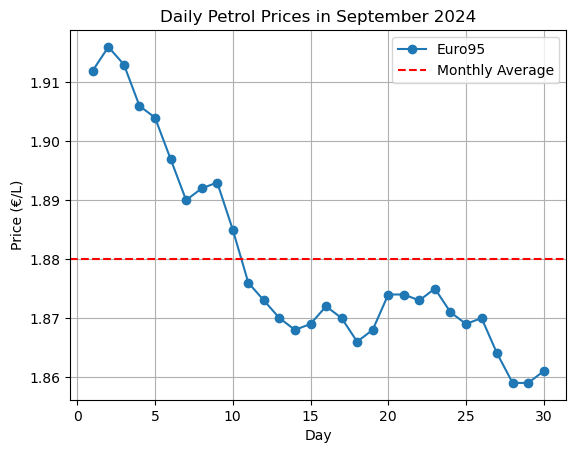

In [ ]:
import matplotlib.pyplot as plt
days = range(1, len(df) + 1)

plt.plot(days, df[fuel_col], marker='o', label='Euro95')
plt.axhline(y=monthly_avg, color='r', linestyle='--', label='Monthly Average')
plt.legend()
plt.title(f'Daily Petrol Prices in September 2024')
plt.xlabel('Day')
plt.ylabel('Price (€/L)');
plt.grid()